<a href="https://colab.research.google.com/github/AmayaDes/Neuro-Symbolic_PCOS-Detection-FYP/blob/main/notebooks/05_CNN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticate
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download
!kaggle datasets download -d amayajayarathna/pcos-ultrasound-dataset-trainvaltest-split

!unzip pcos-ultrasound-dataset-trainvaltest-split.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/amayajayarathna/pcos-ultrasound-dataset-trainvaltest-split
License(s): unknown
  0% 0.00/148M [00:00<?, ?B/s]
100% 148M/148M [00:00<00:00, 1.65GB/s]
Archive:  pcos-ultrasound-dataset-trainvaltest-split.zip
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img1.jpeg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img_0_1084.jpg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img_0_110.jpg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img_0_117.jpg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img_0_1181.jpg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img_0_130.jpg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img_0_1408.jpg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_img_0_1494.jpg  
  inflating: PCOS_Dataset_Split/test/normal/Dataset-1_data_train_im

PCOS CNN TRAINING

STEP 1: LOADING DATA 

 Loading training data...
Found 2783 images belonging to 2 classes.
 Training Generator Created:
 Total images: 2783
 Class indices: {'normal': 0, 'pcos': 1}
 Normal: 1621
 PCOS:   1162

 Loading validation data...
Found 596 images belonging to 2 classes.
 Validation Generator Created: 596 images

 Loading test data...
Found 597 images belonging to 2 classes.
 Test Generator Created: 597 images

BUILDING MODEL - EfficientNetB0
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

 Model built
   Total params: 4,219,300

PHASE 1: FEATURE EXTRACTION (Frozen Base)

 Training Phase 1 (Epochs: 20)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
28/87 ━━━━━━━━━━━━━━━━━━━━ 26s 441ms/step - accuracy: 0.5347 - auc: 0.4895 - loss: 0.9608
 Skipping corrupted image #1: normal/Dataset-1_data_test_img_0_7.jpg
   Error: cannot identify image file <_io.BytesIO object at 0x7db005b22890>
87/87 ━━━━━━━━━━━━━━━━━━━━ 105s 874ms/step - accuracy: 0.5206 - auc: 0.4980 - loss: 0.9345 - val_accuracy: 0.5822 - val_auc: 0.6666 - val_loss: 0.6778 - learning_rate: 0.0010
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 489ms/step - accuracy: 0.5176 - auc: 0.5152 - loss: 0.8049 - val_accuracy: 0.5822 - val_auc: 0.9191 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - accuracy: 0.5581 - auc: 0.5620 - loss: 0.7401 - val_accuracy: 0.5822 - val_auc: 0.9251 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 474ms/step - accuracy: 0.5503 - auc: 0.5862 - loss: 0.7215 - val_accuracy: 0.5822 - val_auc: 0.9183 - val_loss: 0.7022 - learning_rate: 0.0010
Epoch 5/20
87/87 ━━━━━━━

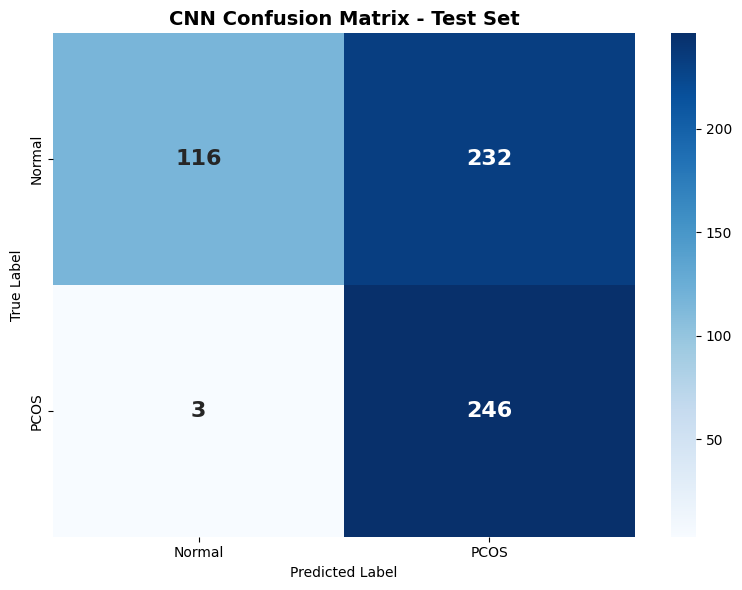

 Saved: roc_curve.png


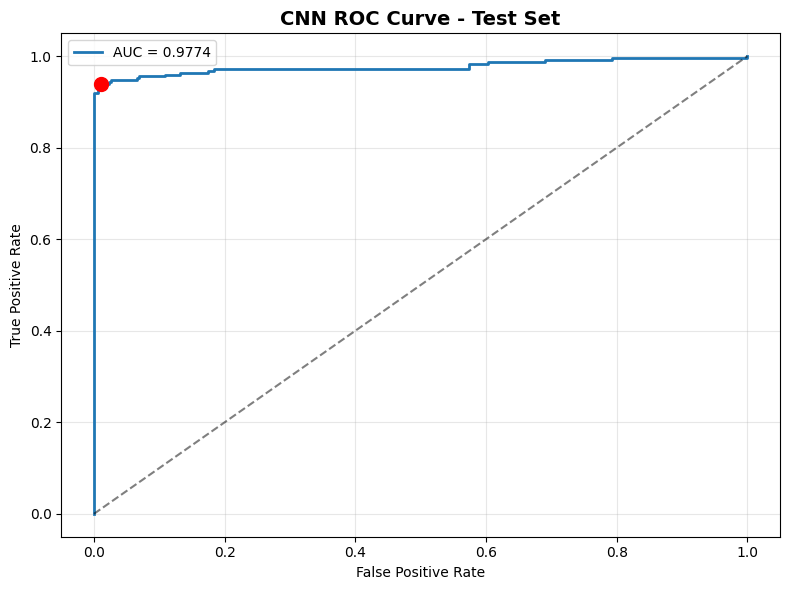

Saved: training_history.png


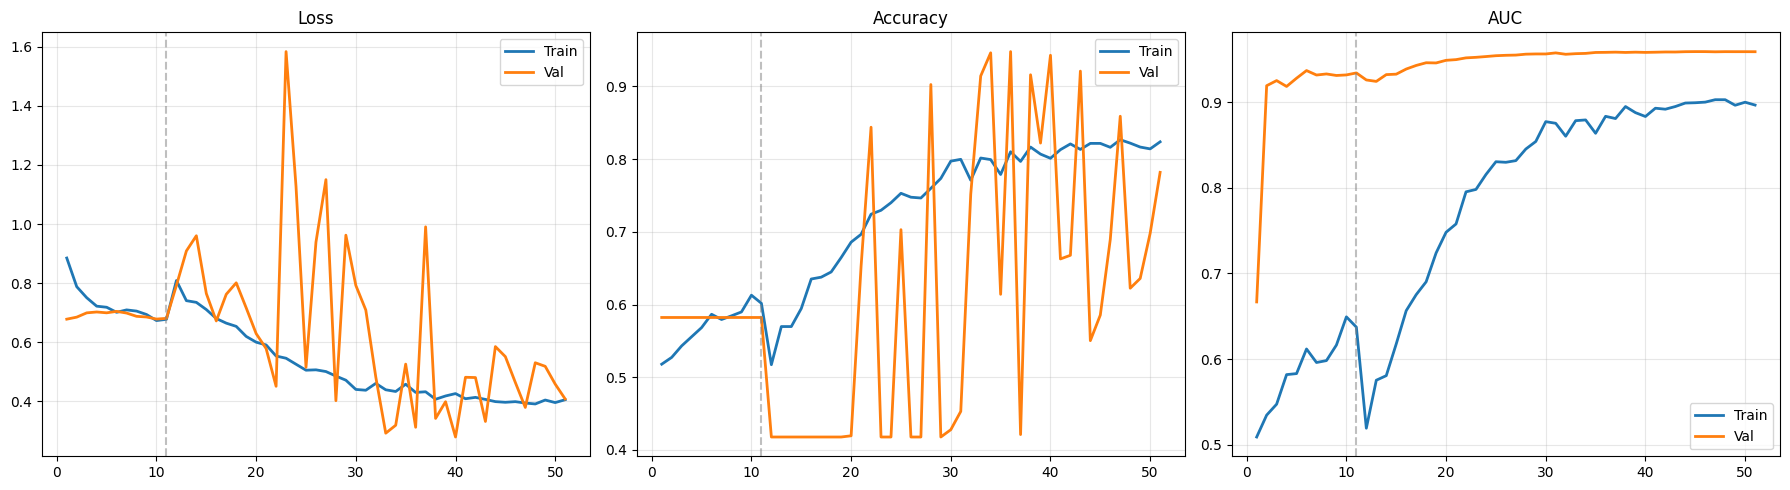


 Final model saved

 TRAINING COMPLETE!

 Final Results:
   Test Accuracy: 0.6064
   Test AUC:      0.9773

 Output: /content/cnn_training_results


In [ ]:
""" PCOS CNN Training """

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# ============================================
# CONFIGURATION
# ============================================

DATASET_DIR = "/content/PCOS_Dataset_Split"
CNN_OUTPUT_DIR = "/content/cnn_training_results"
os.makedirs(CNN_OUTPUT_DIR, exist_ok=True)

GITHUB_BASE_URL = "https://raw.githubusercontent.com/AmayaDes/Neuro-Symbolic_PCOS-Detection-FYP/main/results/"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
PHASE1_EPOCHS = 20
PHASE2_EPOCHS = 40
LEARNING_RATE_PHASE1 = 0.001
LEARNING_RATE_PHASE2 = 0.00005

CLASS_WEIGHTS = {0: 0.858, 1: 1.198}

print("="*70)
print("PCOS CNN TRAINING")
print("="*70)

# ============================================
# SAFE DATA GENERATOR WITH ERROR HANDLING
# ============================================

class SafeDirectoryIterator(keras.preprocessing.image.DirectoryIterator):
    """ Handles image loading safely by skipping unreadable files."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.failed_images = []
        self.failed_count = 0

    def _get_batches_of_transformed_samples(self, index_array):
        """Override to add try-catch error handling"""
        batch_x = []
        batch_y = []

        for i, j in enumerate(index_array):
            try:
                # Get filename
                fname = self.filenames[j]
                img_path = os.path.join(self.directory, fname)

                # Try to load image
                img = keras.preprocessing.image.load_img(
                    img_path,
                    target_size=self.target_size,
                    color_mode=self.color_mode,
                    interpolation=self.interpolation
                )

                # Convert to array
                x = keras.preprocessing.image.img_to_array(img)

                # Apply transformations
                if self.image_data_generator:
                    params = self.image_data_generator.get_random_transform(x.shape)
                    x = self.image_data_generator.apply_transform(x, params)
                    x = self.image_data_generator.standardize(x)

                batch_x.append(x)
                batch_y.append(self.classes[j])

            except Exception as e:
                # Skip corrupted image
                if j not in self.failed_images:
                    self.failed_images.append(j)
                    self.failed_count += 1
                    fname = self.filenames[j] if j < len(self.filenames) else "unknown"
                    print(f"\n Skipping corrupted image #{self.failed_count}: {fname}")
                    print(f"   Error: {str(e)[:80]}")
                continue

        # Handle empty batch
        if len(batch_x) == 0:
            # Return empty batch with correct shape
            batch_x = np.zeros((0, *self.target_size, 3 if self.color_mode == 'rgb' else 1))
            batch_y = np.zeros((0,))
        else:
            batch_x = np.array(batch_x, dtype=self.dtype)
            batch_y = np.array(batch_y, dtype=self.dtype)

        return batch_x, batch_y


class PCOSImageLoader:
    """ Loads images """

    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        self.train_gen = None
        self.val_gen = None
        self.test_gen = None

        # Training augmentation
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=False,
            brightness_range=[0.9, 1.1],
            fill_mode='nearest'
        )

        # Val/test (no augmentation)
        self.val_test_datagen = ImageDataGenerator(rescale=1./255)

    def load_train(self):
        """Load training data with error handling"""

        print(f"\n Loading training data...")

        self.train_gen = SafeDirectoryIterator(
            directory=os.path.join(self.dataset_dir, "train"),
            image_data_generator=self.train_datagen,
            target_size=IMG_SIZE,
            color_mode='rgb',
            classes=['normal', 'pcos'],
            class_mode='binary',
            batch_size=BATCH_SIZE,
            shuffle=True,
            seed=42
        )

        print(f" Training Generator Created:")
        print(f" Total images: {self.train_gen.n}")
        print(f" Class indices: {self.train_gen.class_indices}")
        print(f" Normal: {np.sum(self.train_gen.classes == 0)}")
        print(f" PCOS:   {np.sum(self.train_gen.classes == 1)}")

        return self.train_gen

    def load_val(self):
        """Load validation data with error handling"""

        print(f"\n Loading validation data...")

        self.val_gen = SafeDirectoryIterator(
            directory=os.path.join(self.dataset_dir, "val"),
            image_data_generator=self.val_test_datagen,
            target_size=IMG_SIZE,
            color_mode='rgb',
            classes=['normal', 'pcos'],
            class_mode='binary',
            batch_size=BATCH_SIZE,
            shuffle=False,
            seed=42
        )

        print(f" Validation Generator Created: {self.val_gen.n} images")
        return self.val_gen

    def load_test(self):
        """Load test data with error handling"""
        print(f"\n Loading test data...")

        self.test_gen = SafeDirectoryIterator(
            directory=os.path.join(self.dataset_dir, "test"),
            image_data_generator=self.val_test_datagen,
            target_size=IMG_SIZE,
            color_mode='rgb',
            classes=['normal', 'pcos'],
            class_mode='binary',
            batch_size=BATCH_SIZE,
            shuffle=False,
            seed=42
        )

        print(f" Test Generator Created: {self.test_gen.n} images")
        return self.test_gen


# ============================================
# MODEL BUILDER
# ============================================

def build_model():
    """Build EfficientNetB0-based CNN"""

    print("\n" + "="*70)
    print("BUILDING MODEL - EfficientNetB0")
    print("="*70)

    inputs = layers.Input(shape=(224, 224, 3), name='input_image')

    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(0.4, name='drop1')(x)
    x = layers.Dense(128, activation="relu", name='dense1')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(0.3, name='drop2')(x)
    outputs = layers.Dense(1, activation="sigmoid", name='output')(x)

    model = models.Model(inputs, outputs, name='PCOS_CNN')

    print(f"\n Model built")
    print(f"   Total params: {model.count_params():,}")

    return model, base_model


# ============================================
# VISUALIZATION FUNCTIONS
# ============================================

def plot_confusion_matrix(y_true, y_pred, output_dir):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                xticklabels=["Normal", "PCOS"],
                yticklabels=["Normal", "PCOS"],
                annot_kws={"size": 16, "fontweight": "bold"})
    plt.title("CNN Confusion Matrix - Test Set", fontsize=14, fontweight='bold')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "confusion_matrix.png"), dpi=300)
    print(" Saved: confusion_matrix.png")
    plt.show()
    plt.close()
    return cm


def plot_roc_curve(y_true, y_prob, output_dir):
    """Plot ROC curve"""

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], color='red', s=100, zorder=5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("CNN ROC Curve - Test Set", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "roc_curve.png"), dpi=300)
    print(" Saved: roc_curve.png")
    plt.show()
    plt.close()

    return fpr, tpr, thresholds, roc_auc, best_threshold


def plot_training_history(history_phase1, history_phase2, output_dir):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    all_loss = history_phase1.history['loss'] + history_phase2.history['loss']
    all_val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']
    all_acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
    all_val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
    all_auc = history_phase1.history['auc'] + history_phase2.history['auc']
    all_val_auc = history_phase1.history['val_auc'] + history_phase2.history['val_auc']

    epochs = range(1, len(all_loss) + 1)
    phase1_end = len(history_phase1.history['loss'])

    axes[0].plot(epochs, all_loss, label='Train', linewidth=2)
    axes[0].plot(epochs, all_val_loss, label='Val', linewidth=2)
    axes[0].axvline(phase1_end, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(epochs, all_acc, label='Train', linewidth=2)
    axes[1].plot(epochs, all_val_acc, label='Val', linewidth=2)
    axes[1].axvline(phase1_end, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    axes[2].plot(epochs, all_auc, label='Train', linewidth=2)
    axes[2].plot(epochs, all_val_auc, label='Val', linewidth=2)
    axes[2].axvline(phase1_end, color='gray', linestyle='--', alpha=0.5)
    axes[2].set_title('AUC')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_history.png"), dpi=300)
    print("Saved: training_history.png")
    plt.show()
    plt.close()


# ============================================
# MAIN TRAINING
# ============================================

if __name__ == "__main__":

    # Load data with error handling
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA ")
    print("="*70)

    loader = PCOSImageLoader(DATASET_DIR)
    train_gen = loader.load_train()
    val_gen = loader.load_val()
    test_gen = loader.load_test()

    # Build model
    model, base_model = build_model()

    # Phase 1: Feature extraction
    print("\n" + "="*70)
    print("PHASE 1: FEATURE EXTRACTION (Frozen Base)")
    print("="*70)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    callbacks_phase1 = [
        EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
        ModelCheckpoint(os.path.join(CNN_OUTPUT_DIR, 'best_model_phase1.keras'),
                       monitor='val_auc', save_best_only=True, mode='max')
    ]

    print(f"\n Training Phase 1 (Epochs: {PHASE1_EPOCHS})...")

    history_phase1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=PHASE1_EPOCHS,
        class_weight=CLASS_WEIGHTS,
        callbacks=callbacks_phase1,
        verbose=1
    )

    print(f"\n Phase 1 complete!")

    # Phase 2: Fine-tuning
    print("\n" + "="*70)
    print("PHASE 2: FINE-TUNING (Unfreeze Top Layers)")
    print("="*70)

    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    callbacks_phase2 = [
        EarlyStopping(monitor='val_auc', patience=8, restore_best_weights=True, mode='max'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-8),
        ModelCheckpoint(os.path.join(CNN_OUTPUT_DIR, 'best_model_phase2.keras'),
                       monitor='val_auc', save_best_only=True, mode='max')
    ]

    print(f"\n Training Phase 2 (Epochs: {PHASE2_EPOCHS})...")

    history_phase2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=PHASE2_EPOCHS,
        class_weight=CLASS_WEIGHTS,
        callbacks=callbacks_phase2,
        verbose=1
    )

    print(f"\n Phase 2 complete!")

    # Evaluate on test set
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70)

    y_true = test_gen.classes
    y_prob = model.predict(test_gen, verbose=1).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    test_loss, test_acc, test_auc = model.evaluate(test_gen, verbose=0)

    print(f"\n Test Results:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   AUC:      {test_auc:.4f}")

    print(f"\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'PCOS']))

    # Visualizations
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)

    cm = plot_confusion_matrix(y_true, y_pred, CNN_OUTPUT_DIR)
    fpr, tpr, thresholds, roc_auc, best_threshold = plot_roc_curve(y_true, y_prob, CNN_OUTPUT_DIR)
    plot_training_history(history_phase1, history_phase2, CNN_OUTPUT_DIR)

    # Save model
    model.save(os.path.join(CNN_OUTPUT_DIR, 'final_model.keras'))
    print(f"\n Final model saved")

    # Report failed images
    #loader.report_failed_images()

    # Summary
    print("\n" + "="*70)
    print(" TRAINING COMPLETE!")
    print("="*70)
    print(f"\n Final Results:")
    print(f"   Test Accuracy: {test_acc:.4f}")
    print(f"   Test AUC:      {test_auc:.4f}")
    print(f"\n Output: {CNN_OUTPUT_DIR}")
    print("="*70)


SAVING PREDICTIONS FOR THRESHOLD OPTIMIZATION
 Saved 597 test predictions
 Location: /content/cnn_training_results/test_predictions.csv

THRESHOLD OPTIMIZATION ANALYSIS

 Testing multiple threshold methods...

THRESHOLD COMPARISON

Youden's Index (Balanced):
   Threshold:   0.8381
   Accuracy:    0.9682
   Sensitivity: 0.9398 (Recall)
   Specificity: 0.9885
   Precision:   0.9832
   F1-Score:    0.9610
   FN: 15 | FP: 4

F1-Score Max:
   Threshold:   0.8400
   Accuracy:    0.9665
   Sensitivity: 0.9357 (Recall)
   Specificity: 0.9885
   Precision:   0.9831
   F1-Score:    0.9588
   FN: 16 | FP: 4

Cost-Sensitive (Medical):
   Threshold:   0.7400
   Accuracy:    0.9347
   Sensitivity: 0.9558 (Recall)
   Specificity: 0.9195
   Precision:   0.8947
   F1-Score:    0.9243
   FN: 11 | FP: 28

Target 95% Recall:
   Threshold:   0.7505
   Accuracy:    0.9414
   Sensitivity: 0.9518 (Recall)
   Specificity: 0.9339
   Precision:   0.9115
   F1-Score:    0.9312
   FN: 12 | FP: 23

Balanced Accura

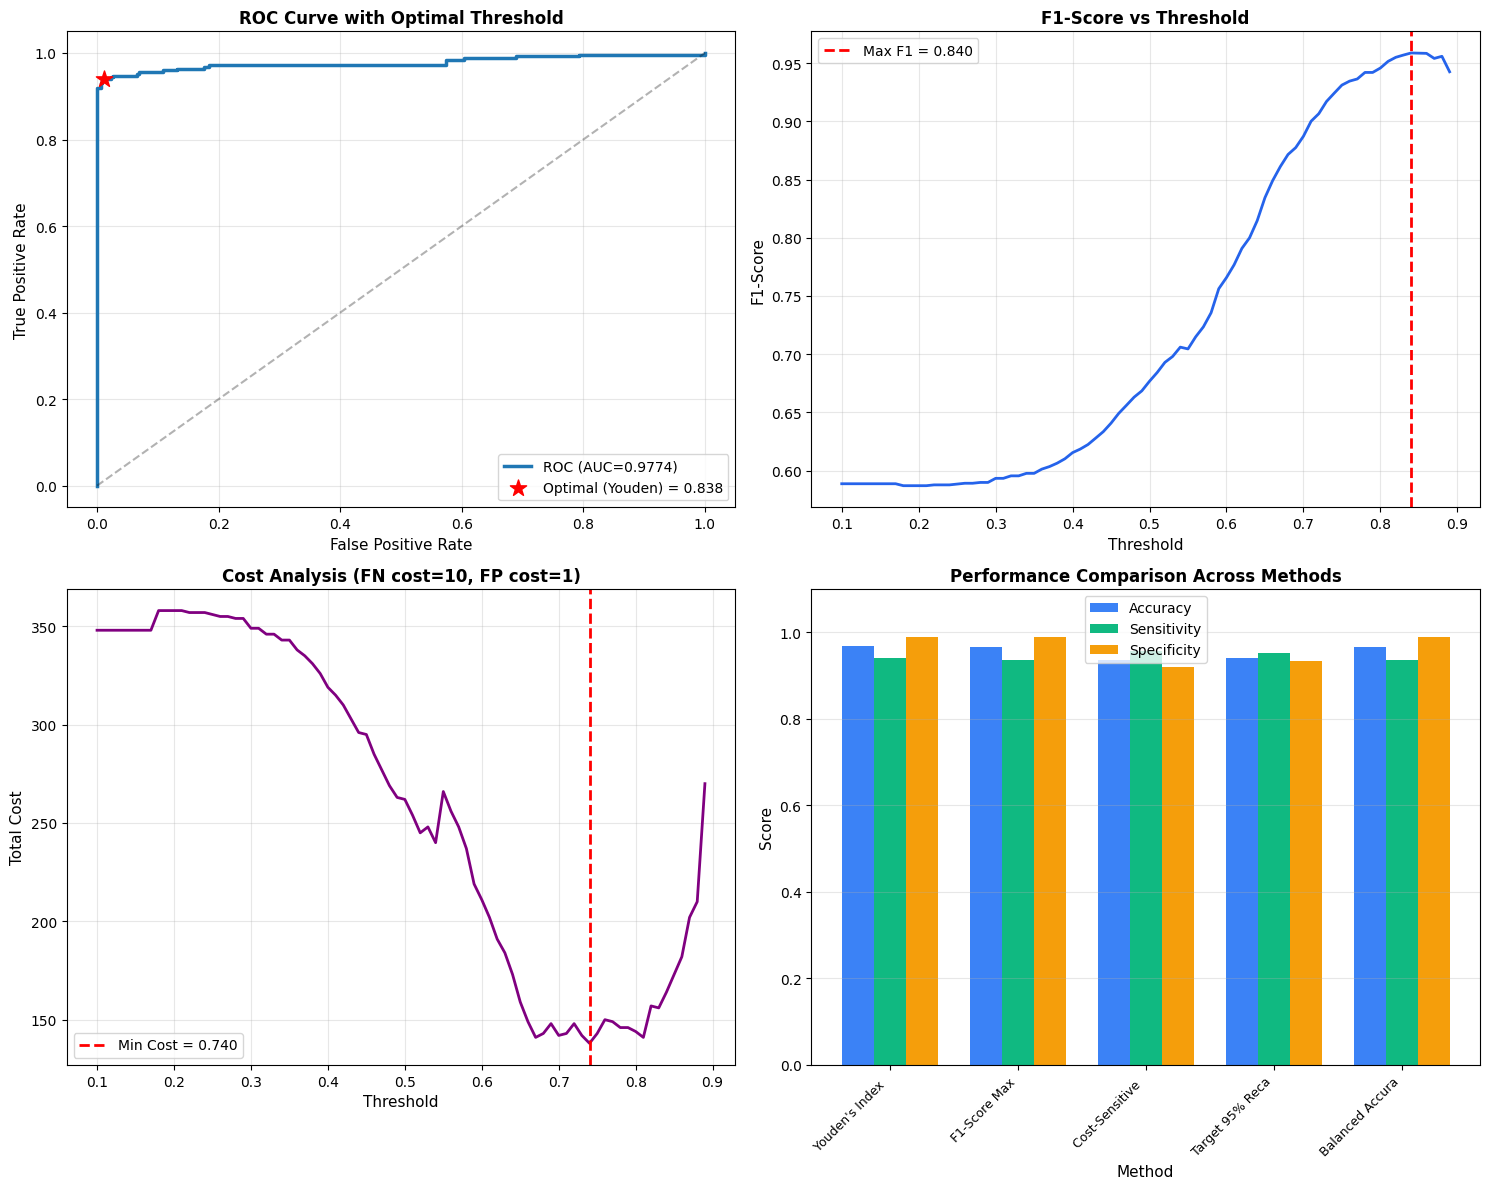


THRESHOLD RECOMMENDATION

 RECOMMENDED THRESHOLD: 0.7400
   Method: Cost-Sensitive (Medical Context)
   Rationale: Prioritizes PCOS detection (false negatives more costly)

 Performance with Recommended Threshold:
   Accuracy:    0.9347
   Sensitivity: 0.9558 (catches 238/249 PCOS cases)
   Specificity: 0.9195
   Precision:   0.8947

   False Negatives: 11 (missed PCOS cases)
   False Positives: 28 (unnecessary follow-ups)

 THRESHOLD OPTIMIZATION COMPLETE!

 All results saved to: /content/cnn_training_results

 Use threshold 0.7400 for clinical deployment

 Saved threshold configuration: optimal_threshold_config.json


In [ ]:

# ============================================
# SAVE PREDICTIONS FOR THRESHOLD ANALYSIS
# ============================================

print("\n" + "="*70)
print("SAVING PREDICTIONS FOR THRESHOLD OPTIMIZATION")
print("="*70)

# Save predictions dataframe
predictions_df = pd.DataFrame({
    'image_index': range(len(y_true)),
    'true_label': y_true,
    'predicted_prob': y_prob,
    'predicted_class_default': y_pred,  # With threshold=0.5
})

predictions_path = os.path.join(CNN_OUTPUT_DIR, 'test_predictions.csv')
predictions_df.to_csv(predictions_path, index=False)

print(f" Saved {len(predictions_df)} test predictions")
print(f" Location: {predictions_path}")


# ============================================
# THRESHOLD OPTIMIZATION
# ============================================

print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION ANALYSIS")
print("="*70)

def analyze_thresholds_quick(y_true, y_prob, output_dir):
    """
    Quick threshold optimization
    """
    from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, confusion_matrix
    import numpy as np

    print("\n Testing multiple threshold methods...")

    results = {}

    # Method 1: Youden's Index
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
    J = tpr - fpr
    optimal_idx_youden = np.argmax(J)
    threshold_youden = thresholds_roc[optimal_idx_youden]

    results['youden'] = {
        'threshold': threshold_youden,
        'name': "Youden's Index (Balanced)",
        'sensitivity': tpr[optimal_idx_youden],
        'specificity': 1 - fpr[optimal_idx_youden]
    }

    # Method 2: F1-Score Maximization
    thresholds_test = np.arange(0.1, 0.9, 0.01)
    f1_scores = []

    for thresh in thresholds_test:
        y_pred_temp = (y_prob >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred_temp)
        f1_scores.append(f1)

    optimal_idx_f1 = np.argmax(f1_scores)
    threshold_f1 = thresholds_test[optimal_idx_f1]

    results['f1_max'] = {
        'threshold': threshold_f1,
        'name': 'F1-Score Max',
        'f1_score': f1_scores[optimal_idx_f1]
    }

    # Method 3: Cost-Sensitive (Medical)
    cost_fn = 10  # Cost of missing PCOS
    cost_fp = 1   # Cost of false alarm

    costs = []
    for thresh in thresholds_test:
        y_pred_temp = (y_prob >= thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred_temp)
        total_cost = (cm[1,0] * cost_fn) + (cm[0,1] * cost_fp)
        costs.append(total_cost)

    optimal_idx_cost = np.argmin(costs)
    threshold_cost = thresholds_test[optimal_idx_cost]

    results['cost_sensitive'] = {
        'threshold': threshold_cost,
        'name': 'Cost-Sensitive (Medical)',
        'total_cost': costs[optimal_idx_cost]
    }

    # Method 4: Target 95% Recall
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)

    target_recall = 0.95
    valid_indices = np.where(recall >= target_recall)[0]

    if len(valid_indices) > 0:
        best_idx = valid_indices[np.argmax(precision[valid_indices])]
        threshold_recall95 = thresholds_pr[best_idx]

        results['target_recall_95'] = {
            'threshold': threshold_recall95,
            'name': 'Target 95% Recall',
            'recall': recall[best_idx],
            'precision': precision[best_idx]
        }

    # Method 5: Balanced Accuracy
    balanced_accs = []
    for thresh in thresholds_test:
        y_pred_temp = (y_prob >= thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred_temp)
        sensitivity = cm[1,1] / (cm[1,0] + cm[1,1] + 1e-10)
        specificity = cm[0,0] / (cm[0,0] + cm[0,1] + 1e-10)
        balanced_acc = (sensitivity + specificity) / 2
        balanced_accs.append(balanced_acc)

    optimal_idx_balanced = np.argmax(balanced_accs)
    threshold_balanced = thresholds_test[optimal_idx_balanced]

    results['balanced'] = {
        'threshold': threshold_balanced,
        'name': 'Balanced Accuracy',
        'balanced_accuracy': balanced_accs[optimal_idx_balanced]
    }

    # Print comparison
    print("\n" + "="*70)
    print("THRESHOLD COMPARISON")
    print("="*70)

    comparison_data = []

    for method, data in results.items():
        thresh = data['threshold']
        y_pred_opt = (y_prob >= thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred_opt)

        tn, fp, fn, tp = cm.ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        comparison_data.append({
            'Method': data['name'],
            'Threshold': thresh,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1': f1,
            'FN': fn,
            'FP': fp
        })

        print(f"\n{data['name']}:")
        print(f"   Threshold:   {thresh:.4f}")
        print(f"   Accuracy:    {accuracy:.4f}")
        print(f"   Sensitivity: {sensitivity:.4f} (Recall)")
        print(f"   Specificity: {specificity:.4f}")
        print(f"   Precision:   {precision:.4f}")
        print(f"   F1-Score:    {f1:.4f}")
        print(f"   FN: {fn} | FP: {fp}")

    # Save comparison
    comparison_df = pd.DataFrame(comparison_data)
    comparison_path = os.path.join(output_dir, 'threshold_comparison.csv')
    comparison_df.to_csv(comparison_path, index=False)
    print(f"\n Saved: threshold_comparison.csv")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: ROC with optimal point
    axes[0, 0].plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC={auc(fpr, tpr):.4f})')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[0, 0].scatter([fpr[optimal_idx_youden]], [tpr[optimal_idx_youden]],
                      color='red', s=150, zorder=5, marker='*',
                      label=f"Optimal (Youden) = {threshold_youden:.3f}")
    axes[0, 0].set_xlabel('False Positive Rate', fontsize=11)
    axes[0, 0].set_ylabel('True Positive Rate', fontsize=11)
    axes[0, 0].set_title('ROC Curve with Optimal Threshold', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(alpha=0.3)

    # Plot 2: F1-Score vs Threshold
    axes[0, 1].plot(thresholds_test, f1_scores, linewidth=2, color='#2563eb')
    axes[0, 1].axvline(threshold_f1, color='red', linestyle='--', linewidth=2,
                      label=f'Max F1 = {threshold_f1:.3f}')
    axes[0, 1].set_xlabel('Threshold', fontsize=11)
    axes[0, 1].set_ylabel('F1-Score', fontsize=11)
    axes[0, 1].set_title('F1-Score vs Threshold', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(alpha=0.3)

    # Plot 3: Cost Analysis
    axes[1, 0].plot(thresholds_test, costs, linewidth=2, color='purple')
    axes[1, 0].axvline(threshold_cost, color='red', linestyle='--', linewidth=2,
                      label=f'Min Cost = {threshold_cost:.3f}')
    axes[1, 0].set_xlabel('Threshold', fontsize=11)
    axes[1, 0].set_ylabel('Total Cost', fontsize=11)
    axes[1, 0].set_title(f'Cost Analysis (FN cost={cost_fn}, FP cost={cost_fp})',
                        fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(alpha=0.3)

    # Plot 4: Comparison Bar Chart
    methods = [d['Method'][:15] for d in comparison_data]
    accuracies = [d['Accuracy'] for d in comparison_data]
    sensitivities = [d['Sensitivity'] for d in comparison_data]
    specificities = [d['Specificity'] for d in comparison_data]

    x = np.arange(len(methods))
    width = 0.25

    axes[1, 1].bar(x - width, accuracies, width, label='Accuracy', color='#3b82f6')
    axes[1, 1].bar(x, sensitivities, width, label='Sensitivity', color='#10b981')
    axes[1, 1].bar(x + width, specificities, width, label='Specificity', color='#f59e0b')

    axes[1, 1].set_xlabel('Method', fontsize=11)
    axes[1, 1].set_ylabel('Score', fontsize=11)
    axes[1, 1].set_title('Performance Comparison Across Methods', fontsize=12, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(methods, rotation=45, ha='right', fontsize=9)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(axis='y', alpha=0.3)
    axes[1, 1].set_ylim([0, 1.1])

    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'threshold_optimization_analysis.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f" Saved: threshold_optimization_analysis.png")
    plt.show()
    plt.close()

    return results, comparison_df


# Run the analysis
results, comparison_df = analyze_thresholds_quick(y_true, y_prob, CNN_OUTPUT_DIR)


# ============================================
# RECOMMENDATION
# ============================================

print("\n" + "="*70)
print("THRESHOLD RECOMMENDATION")
print("="*70)

# Get the cost-sensitive threshold (best for medical screening)
recommended_threshold = results['cost_sensitive']['threshold']

print(f"\n RECOMMENDED THRESHOLD: {recommended_threshold:.4f}")
print(f"   Method: Cost-Sensitive (Medical Context)")
print(f"   Rationale: Prioritizes PCOS detection (false negatives more costly)")

# Evaluate with recommended threshold
y_pred_recommended = (y_prob >= recommended_threshold).astype(int)
cm_recommended = confusion_matrix(y_true, y_pred_recommended)

tn, fp, fn, tp = cm_recommended.ravel()

print(f"\n Performance with Recommended Threshold:")
print(f"   Accuracy:    {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"   Sensitivity: {tp / (tp + fn):.4f} (catches {tp}/{tp+fn} PCOS cases)")
print(f"   Specificity: {tn / (tn + fp):.4f}")
print(f"   Precision:   {tp / (tp + fp):.4f}")
print(f"\n   False Negatives: {fn} (missed PCOS cases)")
print(f"   False Positives: {fp} (unnecessary follow-ups)")

print("\n" + "="*70)
print(" THRESHOLD OPTIMIZATION COMPLETE!")
print("="*70)

print(f"\n All results saved to: {CNN_OUTPUT_DIR}")
print(f"\n Use threshold {recommended_threshold:.4f} for clinical deployment")

# Save recommended threshold
threshold_config = {
    'recommended_threshold': float(recommended_threshold),
    'method': 'cost_sensitive',
    'test_accuracy_at_recommended': float((tp + tn) / (tp + tn + fp + fn)),
    'test_sensitivity_at_recommended': float(tp / (tp + fn)),
    'test_specificity_at_recommended': float(tn / (tn + fp)),
    'false_negatives': int(fn),
    'false_positives': int(fp),
    'default_threshold_accuracy': 0.8023,  # Your original result
    'default_threshold': 0.5
}

import json
config_path = os.path.join(CNN_OUTPUT_DIR, 'optimal_threshold_config.json')
with open(config_path, 'w') as f:
    json.dump(threshold_config, f, indent=4)

print(f"\n Saved threshold configuration: optimal_threshold_config.json")